## 1. 필요한 라이브러리 임포트 및 환경 설정

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# matplotlib 한글 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## 2. BigQuery 연결

In [2]:
# BigQuery 클라이언트 초기화
def get_bigquery_client():
    service_account_path = "/Users/cg01-piwoo/my_quant/access_info/data/quantsungyong-663604552de9.json"
    credentials = service_account.Credentials.from_service_account_file(
        service_account_path,
        scopes=["https://www.googleapis.com/auth/cloud-platform"]
    )
    return bigquery.Client(credentials=credentials, project=credentials.project_id)

client = get_bigquery_client()


# ADX와 Chaikin 지표를 포함한 데이터 로드 함수
def get_stock_data_with_indicators(ticker, start_date=None, end_date=None):
    date_conditions = []
    if start_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') >= '{start_date}'")
    if end_date:
        date_conditions.append(f"JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') <= '{end_date}'")
    
    date_filter = f"AND {' AND '.join(date_conditions)}" if date_conditions else ""
    
    query = f"""
    WITH raw_data AS (
      SELECT 
        ticker,
        -- 가격 데이터
        JSON_EXTRACT_ARRAY(data, '$.dates') AS dates_array,
        JSON_EXTRACT_ARRAY(data, '$.open') AS open_array,
        JSON_EXTRACT_ARRAY(data, '$.high') AS high_array,
        JSON_EXTRACT_ARRAY(data, '$.low') AS low_array,
        JSON_EXTRACT_ARRAY(data, '$.close') AS close_array,
        JSON_EXTRACT_ARRAY(data, '$.volume') AS volume_array,
        
        -- ADX 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.adx_14_values') AS adx_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.pdi_14_values') AS pdi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.mdi_14_values') AS mdi_14_values_array,
        
        -- Chaikin Oscillator 관련 지표 (수정된 필드명)
        JSON_EXTRACT_ARRAY(data, '$.chaikin_oscillator') AS chaikin_oscillator_array,
        JSON_EXTRACT_ARRAY(data, '$.chaikin_9_signal_line') AS chaikin_signal_array,

        -- MACD 관련
        JSON_EXTRACT_ARRAY(data, '$.macd_line') AS macd_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_9_signal_line') AS macd_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_histogram') AS macd_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.macd_signals') AS macd_signals_array,
        
        -- Stochastic
        JSON_EXTRACT_ARRAY(data, '$.stochastic_k_line') AS stochastic_k_line_array,
        JSON_EXTRACT_ARRAY(data, '$.stochastic_d_line') AS stochastic_d_line_array,
        
        -- OBV 관련
        JSON_EXTRACT_ARRAY(data, '$.obv_values') AS obv_values_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_9_ma') AS obv_9_ma_array,
        JSON_EXTRACT_ARRAY(data, '$.obv_signals') AS obv_signals_array,

        -- RSI 관련
        JSON_EXTRACT_ARRAY(data, '$.rsi_14_values') AS rsi_14_values_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_9_signal_line') AS rsi_9_signal_line_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_histogram') AS rsi_histogram_array,
        JSON_EXTRACT_ARRAY(data, '$.rsi_signals') AS rsi_signals_array,
              
        -- ATR 관련 지표
        JSON_EXTRACT_ARRAY(data, '$.atr') AS atr_array,

        -- 배열 길이
        ARRAY_LENGTH(JSON_EXTRACT_ARRAY(data, '$.close')) AS array_length
        
      FROM 
        `quantsungyong.finviz_data.stock_data_with_indicators`
      WHERE 
        ticker = '{ticker}'
    ),
    indices AS (
      SELECT r.ticker, pos
      FROM raw_data r,
      UNNEST(GENERATE_ARRAY(0, r.array_length - 1)) AS pos
    )
    SELECT 
      -- 날짜와 가격 데이터
      JSON_EXTRACT_SCALAR(r.dates_array[OFFSET(i.pos)], '$') AS date,
      CAST(JSON_EXTRACT_SCALAR(r.open_array[OFFSET(i.pos)], '$') AS FLOAT64) AS open,
      CAST(JSON_EXTRACT_SCALAR(r.high_array[OFFSET(i.pos)], '$') AS FLOAT64) AS high,
      CAST(JSON_EXTRACT_SCALAR(r.low_array[OFFSET(i.pos)], '$') AS FLOAT64) AS low,
      CAST(JSON_EXTRACT_SCALAR(r.close_array[OFFSET(i.pos)], '$') AS FLOAT64) AS close,
      CAST(JSON_EXTRACT_SCALAR(r.volume_array[OFFSET(i.pos)], '$') AS INT64) AS volume,
      
      -- RSI 관련
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.rsi_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS rsi_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.rsi_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.rsi_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS rsi_signals,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      
      -- ATR 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.atr_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.atr_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS atr,
      -- ADX 관련 지표
      CASE 
        WHEN ARRAY_LENGTH(r.adx_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.adx_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS adx_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.pdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.pdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS pdi_14,
      
      CASE 
        WHEN ARRAY_LENGTH(r.mdi_14_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.mdi_14_values_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS mdi_14,
      
      -- Chaikin Oscillator (수정된 필드명)
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_oscillator_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_oscillator_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_oscillator,
      
      CASE 
        WHEN ARRAY_LENGTH(r.chaikin_signal_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.chaikin_signal_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS chaikin_signal,

      -- Stochastic
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_k_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_k_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_k_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.stochastic_d_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.stochastic_d_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS stochastic_d_line,

      -- MACD 관련
      CASE 
        WHEN ARRAY_LENGTH(r.macd_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_9_signal_line_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_9_signal_line_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_9_signal_line,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_histogram_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.macd_histogram_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS macd_histogram,
      
      CASE 
        WHEN ARRAY_LENGTH(r.macd_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.macd_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS macd_signals,
      
      -- OBV 관련
      CASE 
        WHEN ARRAY_LENGTH(r.obv_values_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_values_array[OFFSET(i.pos)], '$') AS INT64)
        ELSE NULL 
      END AS obv_values,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_9_ma_array) > i.pos 
        THEN CAST(JSON_EXTRACT_SCALAR(r.obv_9_ma_array[OFFSET(i.pos)], '$') AS FLOAT64)
        ELSE NULL 
      END AS obv_9_ma,
      
      CASE 
        WHEN ARRAY_LENGTH(r.obv_signals_array) > i.pos 
        THEN JSON_EXTRACT_SCALAR(r.obv_signals_array[OFFSET(i.pos)], '$')
        ELSE NULL 
      END AS obv_signals

    FROM raw_data r
    CROSS JOIN indices i
    WHERE i.ticker = r.ticker {date_filter}
    ORDER BY date DESC
    """
    
    try:
        df = client.query(query).to_dataframe()
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)
        # Chaikin의 전일 값 계산
        df['chaikin_yesterday'] = df['chaikin_oscillator'].shift(1)

        print(f"✅ {ticker} 데이터 로드 완료: {len(df)}개 레코드")
        return df
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

## 3. ATR 기반 백테스트 전략 함수 정의

### 함수1

In [22]:
# ATR 계산 함수
def calculate_atr(df, period=14):
    """
    ATR (Average True Range) 계산
    
    Parameters:
    - df: DataFrame with 'high', 'low', 'close' columns
    - period: ATR 계산 기간 (기본 14)
    
    Returns:
    - Series: ATR values
    """
    # True Range 계산
    high_low = df['high'].shift(1) - df['low'].shift(1)
    high_close = np.abs(df['high'].shift(1) - df['close'].shift(2))
    low_close = np.abs(df['low'].shift(1) - df['close'].shift(2))
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    # ATR 계산 (단순이동평균)
    atr = tr.rolling(window=period).mean()
    
    return atr


### 함수2

In [23]:
def backtest_atr_strategy(ticker, df, initial_capital=100000, 
                         atr_entry_multiplier=0.5,  # ATR의 몇 배 이상 움직이면 매수
                         stop_loss_atr=1.5,         # 손절선: ATR의 몇 배
                         take_profit_atr=3.0,       # 익절선: ATR의 몇 배
                         position_size_atr=2.0,     # 포지션 사이징: 자본금의 2%를 ATR 1배로 나눔
                         commission_rate=0.001,     # 거래수수료 0.1%
                         slippage_rate=0.001,      # 슬리피지 0.1%
                         atr_period=14):            # ATR 계산 기간
    """
    ATR 기반 변동성 돌파 전략 백테스트
    
    매수 조건 (현실적인 접근):
    1. 어제 ATR 기반으로 오늘 변동성 돌파 가격 설정
    2. 돌파가격 = 오늘 시가 + (어제 ATR * multiplier)
    3. 오늘 고가가 돌파가격을 상향 돌파하면 매수
    
    포지션 사이징:
    - 리스크 = 자본금의 2%
    - 포지션 크기 = 리스크 / (ATR * stop_loss_atr)
    
    청산 조건:
    1. 손절: 매수가 - (ATR * stop_loss_atr)
    2. 익절: 매수가 + (ATR * take_profit_atr)
    """
    
    # ATR 계산 (calculate_atr 함수 사용)
    df = df.copy()  # 원본 데이터프레임 보호
    df['atr'] = calculate_atr(df, period=atr_period)
    
    # 전일 ATR 추가
    df['prev_atr'] = df['atr'].shift(1)
    
    # 백테스트 결과 저장용 변수
    cash = initial_capital
    position = 0
    entry_price = 0
    entry_atr = 0
    trades = []
    
    # 일별 수익률 및 포트폴리오 가치
    portfolio_values = []
    daily_returns = []
    positions = []  # 매일의 포지션 수
    
    for i in range(len(df)):
        date = df.index[i]
        row = df.iloc[i]
        
        # 첫날이거나 전일 ATR이 없으면 스킵
        if i == 0 or pd.isna(row['prev_atr']) or row['prev_atr'] <= 0:
            portfolio_value = cash + (position * row['close'] if position > 0 else 0)
            portfolio_values.append(portfolio_value)
            daily_returns.append(0)
            positions.append(position)
            continue
        
        # 포지션이 없을 때 - 진입 조건 확인
        if position == 0:
            # 변동성 돌파 가격 계산 (어제 ATR 기반)
            breakout_price = row['open'] + (row['prev_atr'] * atr_entry_multiplier)
            
            # 오늘 고가가 돌파 가격을 넘으면 매수
            if row['high'] > breakout_price:
                # 실제 매수가는 돌파 가격 (더 현실적)
                buy_price = breakout_price * (1 + slippage_rate)
                
                # 매수가가 오늘 고가를 넘으면 고가로 제한
                buy_price = min(buy_price, row['high'])
                
                # 포지션 사이징
                risk_amount = cash * 0.02  # 자본금의 2%
                stop_loss_distance = row['prev_atr'] * stop_loss_atr
                position_value = risk_amount / stop_loss_distance * buy_price
                
                # 최대 자본금의 50%까지만 사용
                position_value = min(position_value, cash * 0.5)
                
                # 매수 실행
                shares = int(position_value / buy_price)
                
                if shares > 0 and shares * buy_price <= cash:
                    position = shares
                    entry_price = buy_price
                    entry_atr = row['prev_atr']  # 어제 ATR 기록
                    cash -= shares * buy_price * (1 + commission_rate)
                    
                    trades.append({
                        'ticker': ticker,
                        'entry_date': date,
                        'entry_price': entry_price,
                        'shares': shares,
                        'entry_atr': entry_atr,
                        'stop_loss': entry_price - (entry_atr * stop_loss_atr),
                        'take_profit': entry_price + (entry_atr * take_profit_atr),
                        'position_value': shares * entry_price,
                        'breakout_price': breakout_price
                    })
        
        # 포지션이 있을 때 - 청산 조건 확인
        else:
            stop_loss = entry_price - (entry_atr * stop_loss_atr)
            take_profit = entry_price + (entry_atr * take_profit_atr)
            
            exit_signal = False
            exit_reason = ""
            exit_price = 0
            
            # 손절 확인
            if row['low'] <= stop_loss:
                exit_price = stop_loss * (1 - slippage_rate)
                exit_signal = True
                exit_reason = "stop_loss"
            # 익절 확인
            elif row['high'] >= take_profit:
                exit_price = take_profit * (1 - slippage_rate)
                exit_signal = True
                exit_reason = "take_profit"
            
            # 청산 실행
            if exit_signal:
                # 실제 체결 가능한 가격으로 조정
                if exit_reason == "stop_loss":
                    exit_price = max(exit_price, row['low'])
                elif exit_reason == "take_profit":
                    exit_price = min(exit_price, row['high'])
                
                cash += position * exit_price * (1 - commission_rate)
                
                # 거래 기록 업데이트
                trades[-1].update({
                    'exit_date': date,
                    'exit_price': exit_price,
                    'exit_reason': exit_reason,
                    'return': (exit_price - entry_price) / entry_price,
                    'profit_loss': position * (exit_price - entry_price)
                })
                
                position = 0
                entry_price = 0
                entry_atr = 0
        
        # 포트폴리오 가치 계산
        portfolio_value = cash + (position * row['close'] if position > 0 else 0)
        portfolio_values.append(portfolio_value)
        
        # 일별 수익률 계산
        if i > 0:
            daily_return = (portfolio_value - portfolio_values[i-1]) / portfolio_values[i-1]
            daily_returns.append(daily_return)
        else:
            daily_returns.append(0)
        
        positions.append(position)
    
    # 마지막에 포지션이 남아있다면 청산
    if position > 0:
        final_price = df.iloc[-1]['close'] * (1 - slippage_rate)
        cash += position * final_price * (1 - commission_rate)
        
        trades[-1].update({
            'exit_date': df.index[-1],
            'exit_price': final_price,
            'exit_reason': 'end_of_period',
            'return': (final_price - entry_price) / entry_price,
            'profit_loss': position * (final_price - entry_price)
        })
        
        portfolio_values[-1] = cash
    
    # 결과 DataFrame 생성
    trades_df = pd.DataFrame(trades)
    
    # 포트폴리오 DataFrame 생성 (추가 필드 포함)
    portfolio_df = pd.DataFrame({
        'date': df.index,
        'portfolio_value': portfolio_values,
        'daily_returns': daily_returns,
        'position': positions,
        'close': df['close'].values,
        'atr': df['atr'].values
    })
    portfolio_df.set_index('date', inplace=True)
    
    # 누적 수익률 계산
    portfolio_df['cumulative_returns'] = (1 + portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 수익률 계산
    portfolio_df['buy_hold_returns'] = portfolio_df['close'] / portfolio_df['close'].iloc[0]
    
    # 전략 vs Buy & Hold 비교
    portfolio_df['strategy_vs_buyhold'] = portfolio_df['cumulative_returns'] / portfolio_df['buy_hold_returns']
    
    return trades_df, portfolio_df

### 함수3

In [ ]:
def analyze_backtest_results(trades_df, portfolio_df, initial_capital=100000):
    """백테스트 결과 분석"""
    
    results = {}
    
    # 기본 통계
    results['total_trades'] = len(trades_df)
    results['initial_capital'] = initial_capital
    results['final_portfolio_value'] = portfolio_df['portfolio_value'].iloc[-1]
    results['total_return'] = (results['final_portfolio_value'] - initial_capital) / initial_capital
    
    if len(trades_df) > 0:
        completed_trades = trades_df[trades_df['exit_date'].notna()]
        
        if len(completed_trades) > 0:
            # 승률
            winning_trades = completed_trades[completed_trades['profit_loss'] > 0]
            results['win_rate'] = len(winning_trades) / len(completed_trades)
            
            # 평균 수익률
            results['avg_return'] = completed_trades['return'].mean()
            results['avg_win'] = winning_trades['return'].mean() if len(winning_trades) > 0 else 0
            results['avg_loss'] = completed_trades[completed_trades['profit_loss'] <= 0]['return'].mean()
            
            # 손익비
            if results['avg_loss'] != 0:
                results['profit_factor'] = abs(results['avg_win'] / results['avg_loss'])
            else:
                results['profit_factor'] = float('inf') if results['avg_win'] > 0 else 0
            
            # 청산 이유별 통계
            results['exit_reasons'] = completed_trades['exit_reason'].value_counts().to_dict()
    
    # 최대 낙폭 (MDD)
    cummax = portfolio_df['portfolio_value'].cummax()
    drawdown = (portfolio_df['portfolio_value'] - cummax) / cummax
    results['max_drawdown'] = drawdown.min()
    
    # 일별 수익률 사용 (portfolio_df에 이미 있음)
    daily_returns = portfolio_df['daily_returns'].dropna()
    
    if len(daily_returns) > 0:
        # 샤프비율 (연환산, 무위험수익률 2%)
        results['sharpe_ratio'] = (daily_returns.mean() * 252 - 0.02) / (daily_returns.std() * np.sqrt(252))
        
        # 소르티노 비율 (하방 변동성만 고려, 무위험수익률 2%)
        # 목표 수익률을 무위험 수익률로 설정
        target_return = 0.02 / 252  # 일별 목표 수익률
        downside_returns = daily_returns[daily_returns < target_return] - target_return
        
        if len(downside_returns) > 0:
            downside_std = np.sqrt((downside_returns ** 2).mean())
            results['sortino_ratio'] = (daily_returns.mean() * 252 - 0.02) / (downside_std * np.sqrt(252))
        else:
            # 손실이 없는 경우
            results['sortino_ratio'] = float('inf') if daily_returns.mean() > 0 else 0
    else:
        results['sharpe_ratio'] = 0
        results['sortino_ratio'] = 0
    
    return results

### 함수4 - 포트폴리오 통합 성과 분석

In [ ]:
def portfolio_integrated_backtest(stock_data_dict, initial_capital=100000,
                                atr_entry_multiplier=0.5,
                                stop_loss_atr=1.5,
                                take_profit_atr=3.0,
                                position_size_atr=2.0,
                                commission_rate=0.001,
                                slippage_rate=0.001,
                                atr_period=14,
                                allocation_method='equal'):  # equal, volatility_weighted
    """
    포트폴리오 통합 백테스트
    
    여러 종목을 동시에 운용하는 포트폴리오의 통합 성과를 분석
    
    Parameters:
    - stock_data_dict: {ticker: df} 형태의 딕셔너리
    - allocation_method: 'equal' (균등 배분) 또는 'volatility_weighted' (변동성 가중)
    
    Returns:
    - all_trades_df: 모든 종목의 거래 내역
    - integrated_portfolio_df: 통합 포트폴리오 성과
    - ticker_allocation: 종목별 자금 배분 비율
    """
    
    # 종목 수와 종목별 초기 자본 설정
    n_tickers = len(stock_data_dict)
    
    if allocation_method == 'equal':
        # 균등 배분
        ticker_capital = {ticker: initial_capital / n_tickers for ticker in stock_data_dict.keys()}
    else:
        # 변동성 가중 배분 (ATR 역수 비례)
        avg_atrs = {}
        for ticker, df in stock_data_dict.items():
            df_copy = df.copy()
            df_copy['atr'] = calculate_atr(df_copy, period=atr_period)
            avg_atrs[ticker] = df_copy['atr'].mean()
        
        # ATR 역수로 가중치 계산
        weights = {ticker: 1/atr for ticker, atr in avg_atrs.items()}
        total_weight = sum(weights.values())
        ticker_capital = {ticker: (weight/total_weight) * initial_capital 
                         for ticker, weight in weights.items()}
    
    # 종목별 백테스트 실행
    ticker_results = {}
    all_trades = []
    
    for ticker, df in stock_data_dict.items():
        trades_df, portfolio_df = backtest_atr_strategy(
            ticker, df, 
            ticker_capital[ticker],  # 종목별 할당 자본
            atr_entry_multiplier=atr_entry_multiplier,
            stop_loss_atr=stop_loss_atr,
            take_profit_atr=take_profit_atr,
            position_size_atr=position_size_atr,
            commission_rate=commission_rate,
            slippage_rate=slippage_rate,
            atr_period=atr_period
        )
        
        # 결과 저장
        ticker_results[ticker] = {
            'trades_df': trades_df,
            'portfolio_df': portfolio_df,
            'allocation': ticker_capital[ticker] / initial_capital
        }
        
        if len(trades_df) > 0:
            trades_df['allocation'] = ticker_capital[ticker] / initial_capital
            all_trades.append(trades_df)
    
    # 통합 포트폴리오 생성
    # 모든 날짜 범위 찾기
    all_dates = set()
    for ticker, results in ticker_results.items():
        all_dates.update(results['portfolio_df'].index)
    all_dates = sorted(list(all_dates))
    
    # 일별 통합 포트폴리오 가치 계산
    integrated_values = []
    integrated_returns = []
    ticker_values = {ticker: [] for ticker in stock_data_dict.keys()}
    
    for date in all_dates:
        daily_total = 0
        daily_ticker_values = {}
        
        for ticker, results in ticker_results.items():
            portfolio_df = results['portfolio_df']
            if date in portfolio_df.index:
                value = portfolio_df.loc[date, 'portfolio_value']
            else:
                # 해당 날짜에 데이터가 없으면 가장 가까운 이전 값 사용
                prev_dates = portfolio_df.index[portfolio_df.index <= date]
                if len(prev_dates) > 0:
                    value = portfolio_df.loc[prev_dates[-1], 'portfolio_value']
                else:
                    value = ticker_capital[ticker]  # 초기 자본
            
            daily_total += value
            daily_ticker_values[ticker] = value
            ticker_values[ticker].append(value)
        
        integrated_values.append(daily_total)
        
        # 일별 수익률 계산
        if len(integrated_values) > 1:
            daily_return = (integrated_values[-1] - integrated_values[-2]) / integrated_values[-2]
        else:
            daily_return = 0
        integrated_returns.append(daily_return)
    
    # 통합 포트폴리오 DataFrame 생성
    integrated_portfolio_df = pd.DataFrame({
        'date': all_dates,
        'portfolio_value': integrated_values,
        'daily_returns': integrated_returns
    })
    integrated_portfolio_df.set_index('date', inplace=True)
    
    # 종목별 포트폴리오 가치 추가
    for ticker in stock_data_dict.keys():
        integrated_portfolio_df[f'{ticker}_value'] = ticker_values[ticker]
    
    # 누적 수익률 계산
    integrated_portfolio_df['cumulative_returns'] = (1 + integrated_portfolio_df['daily_returns']).cumprod()
    
    # Buy & Hold 수익률 계산 (각 종목의 Buy & Hold 가중 평균) - 타입 변환 수정
    integrated_portfolio_df['buy_hold_returns'] = 0.0  # float로 초기화
    for ticker, results in ticker_results.items():
        portfolio_df = results['portfolio_df']
        allocation = results['allocation']
        
        # 해당 종목의 Buy & Hold 수익률에 배분 비율을 곱해서 더함
        for date in integrated_portfolio_df.index:
            if date in portfolio_df.index:
                bh_return = float(portfolio_df.loc[date, 'buy_hold_returns'])  # float로 변환
                integrated_portfolio_df.loc[date, 'buy_hold_returns'] += bh_return * allocation
    
    # 전략 vs Buy & Hold
    integrated_portfolio_df['strategy_vs_buyhold'] = (
        integrated_portfolio_df['cumulative_returns'] / integrated_portfolio_df['buy_hold_returns']
    )
    
    # 종목별 비중 계산
    for ticker in stock_data_dict.keys():
        integrated_portfolio_df[f'{ticker}_weight'] = (
            integrated_portfolio_df[f'{ticker}_value'] / integrated_portfolio_df['portfolio_value']
        )
    
    # 모든 거래 통합
    if all_trades:
        all_trades_df = pd.concat(all_trades, ignore_index=True)
    else:
        all_trades_df = pd.DataFrame()
    
    # 통합 성과 분석
    integrated_results = analyze_backtest_results(
        all_trades_df, integrated_portfolio_df, initial_capital
    )
    
    return all_trades_df, integrated_portfolio_df, ticker_results, integrated_results

## 4. 데이터 로드

In [51]:
ETF = ['UST','UBT','SCO','ZSL','UJB','AGQ','UGL','YCS','RXD','TBF','TBX','KOLD','UCO','TQQQ','SQQQ','VDE','IWM']
classic_etf_leverage = ['TQQQ','SQQQ','ERX','UBT','UGL','YCL','YCS','TBT','FAS','URTY']
sector = ['XLC','XLY','XLP','XLF','XLI','XLB','XLK','XLE','XLRE','XLV']
sector_leverage = ['UCC', 'UGE', 'UYG', 'UXI', 'UYM', 'URE', 'RXL','SOXL','TECL']
top_safe = ['TQQQ','SQQQ','UGL','URTY', 'FAS']
exp_1 = ['TQQQ','SQQQ','ERX','UBT','UGL','TBT','FAS','URTY']
exp_2 = ['UBT','UGL','TBT']
exp_3 = ['TQQQ','SQQQ','FAS','UGL','RXL','UYG','AGQ','KOLD','UCO','SCO','YINN']
inverse_etf = ['ERY','SOXS','TECS','FAZ']
theme_sector = ['SHLD','ERX','VXX','TZA','UNG']
risk_hedge_etf = ['TAIL','FXY','IDOG','BTAL','FGM','ONEQ','VXX']
국가_etf = ['XPP','IVLU','EWH','LDEM','EFNL','FEUZ','FGM','EWG','FGM','YINN','KSTR','FLGR','KTEC','EWO','ENIC','EWS']
it_captins = ['TSLA','AMZN','GOOGL','MSFT','NVDA','META','NFLX']
it_captins_leverage = ['TSLR','NVDL','FBL','AMZZ','MSFL','NFLX','GOOGL']
buy_aug_xxii = ['EWG','EWH','IWM','SOXL']
finviz=[
'RTO',
'SLNH',
'WKSP',
'COMM',
'FIZZ',
'VBTX',
'THM',
'MATX',
'CLSK',
'JNK',
'AFYA',
'STIM',
'CWB',
'AG',
'XYZ',
'MLPX',
'SSB',
'CLMT',
'NFLX',
'GFF',
]
# 분석 대상 종목
tickers =  classic_etf_leverage
start_date = '2015-05-28'

# 데이터 로드
stock_data = {}
for ticker in tickers:
    df = get_stock_data_with_indicators(ticker, start_date)
    if df is not None and len(df) > 0:
        stock_data[ticker] = df
    else:
        print(f"⚠️ {ticker} 데이터 로드 실패 또는 비어있음")

print(f"\n✅ 총 {len(stock_data)}개 종목 데이터 로드 완료")

✅ TQQQ 데이터 로드 완료: 2513개 레코드
✅ SQQQ 데이터 로드 완료: 2513개 레코드
✅ ERX 데이터 로드 완료: 2513개 레코드
✅ UBT 데이터 로드 완료: 2513개 레코드
✅ UGL 데이터 로드 완료: 2513개 레코드
✅ YCL 데이터 로드 완료: 2513개 레코드
✅ YCS 데이터 로드 완료: 2513개 레코드
✅ TBT 데이터 로드 완료: 2513개 레코드
✅ FAS 데이터 로드 완료: 2513개 레코드
✅ URTY 데이터 로드 완료: 2513개 레코드

✅ 총 10개 종목 데이터 로드 완료


## 5. ATR 전략 백테스트 실행

In [72]:
# 백테스트 파라미터 설정
initial_capital = 100000
atr_entry_multiplier = 0.3  # ATR의 0.3배 (더 민감하게 조정)
stop_loss_atr = 0.01         # 손절선: ATR의 0.03배
take_profit_atr = 1.1       # 익절선: ATR의 3배

# 종목별 백테스트 결과 저장
all_results = {}
all_trades = []

for ticker, df in stock_data.items():
    print(f"\n📊 {ticker} 백테스트 진행중...")
    
    # 백테스트 실행
    trades_df, portfolio_df = backtest_atr_strategy(
        ticker, df, initial_capital,
        atr_entry_multiplier=atr_entry_multiplier,
        stop_loss_atr=stop_loss_atr,
        take_profit_atr=take_profit_atr
    )
    
    # 결과 분석
    results = analyze_backtest_results(trades_df, portfolio_df, initial_capital)
    all_results[ticker] = results
    
    if len(trades_df) > 0:
        all_trades.append(trades_df)
    
    # 결과 출력
    print(f"- 총 거래 수: {results['total_trades']}")
    print(f"- 최종 수익률: {results['total_return']:.2%}")
    print(f"- 승률: {results.get('win_rate', 0):.2%}")
    print(f"- 최대 낙폭: {results['max_drawdown']:.2%}")
    print(f"- 샤프 비율: {results['sharpe_ratio']:.2f}")


📊 TQQQ 백테스트 진행중...
- 총 거래 수: 860
- 최종 수익률: 3797.04%
- 승률: 23.72%
- 최대 낙폭: -9.58%
- 샤프 비율: 1.81

📊 SQQQ 백테스트 진행중...
- 총 거래 수: 825
- 최종 수익률: 881.72%
- 승률: 17.33%
- 최대 낙폭: -7.82%
- 샤프 비율: 1.21

📊 ERX 백테스트 진행중...
- 총 거래 수: 851
- 최종 수익률: 2958.28%
- 승률: 20.09%
- 최대 낙폭: -20.99%
- 샤프 비율: 1.60

📊 UBT 백테스트 진행중...
- 총 거래 수: 749
- 최종 수익률: 101.83%
- 승률: 21.63%
- 최대 낙폭: -6.00%
- 샤프 비율: 0.67

📊 UGL 백테스트 진행중...
- 총 거래 수: 753
- 최종 수익률: 171.27%
- 승률: 25.23%
- 최대 낙폭: -3.72%
- 샤프 비율: 1.16

📊 YCL 백테스트 진행중...
- 총 거래 수: 478
- 최종 수익률: 3.80%
- 승률: 29.08%
- 최대 낙폭: -6.39%
- 샤프 비율: -0.49

📊 YCS 백테스트 진행중...
- 총 거래 수: 643
- 최종 수익률: 24.96%
- 승률: 28.77%
- 최대 낙폭: -8.29%
- 샤프 비율: 0.08

📊 TBT 백테스트 진행중...
- 총 거래 수: 782
- 최종 수익률: 145.50%
- 승률: 23.02%
- 최대 낙폭: -4.88%
- 샤프 비율: 0.96

📊 FAS 백테스트 진행중...
- 총 거래 수: 851
- 최종 수익률: 2187.24%
- 승률: 22.56%
- 최대 낙폭: -12.01%
- 샤프 비율: 1.81

📊 URTY 백테스트 진행중...
- 총 거래 수: 846
- 최종 수익률: 3155.13%
- 승률: 21.51%
- 최대 낙폭: -13.44%
- 샤프 비율: 1.75


### 6. 결과 시각화

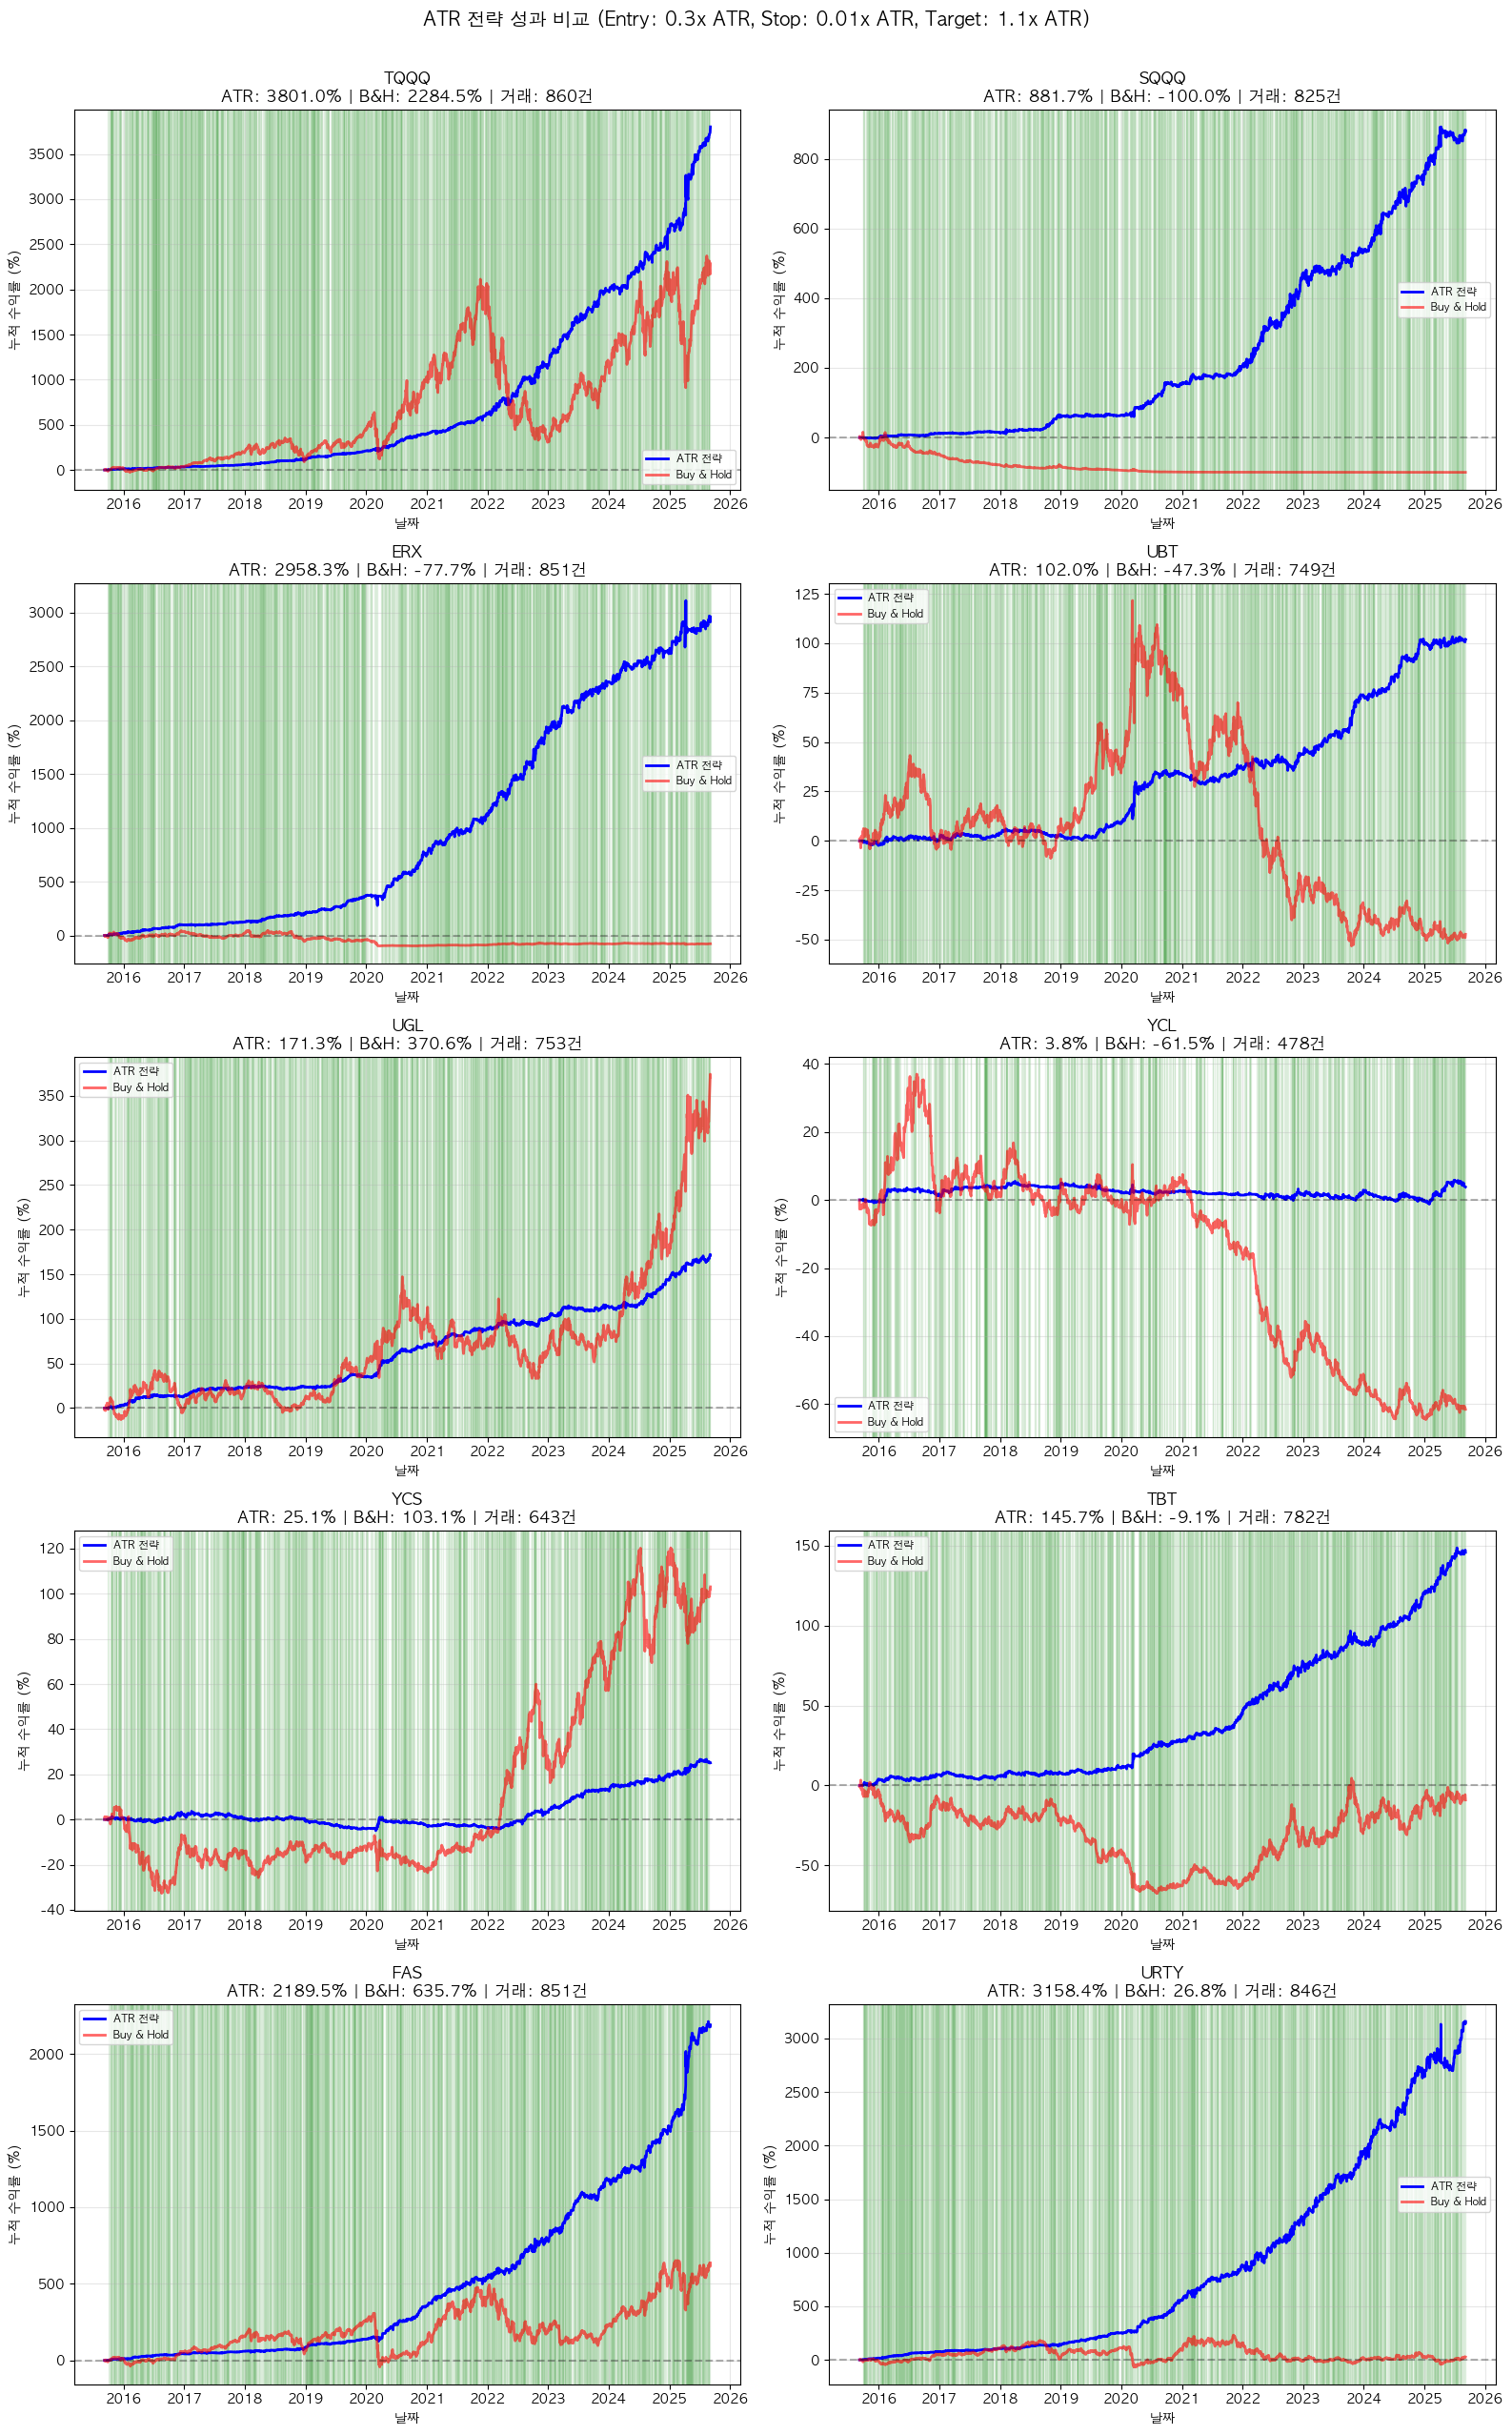


=== 전체 종목 성과 요약 ===
  종목  ATR 전략(%)  Buy&Hold(%)    초과수익(%)  거래횟수  승률(%)  MDD(%)  샤프비율  소르티노
TQQQ    3800.97      2284.49      63.60   860   23.7    -9.6  1.81     0
URTY    3158.41        26.76    2470.59   846   21.5   -13.4  1.75     0
 ERX    2958.28       -77.69   13608.20   851   20.1   -21.0  1.60     0
 FAS    2189.54       635.73     211.19   851   22.6   -12.0  1.81     0
SQQQ     881.72       -99.96 2216741.46   825   17.3    -7.8  1.21     0
 UGL     171.27       370.59     -42.35   753   25.2    -3.7  1.16     0
 TBT     145.75        -9.07     170.25   782   23.0    -4.9  0.96     0
 UBT     102.03       -47.30     283.40   749   21.6    -6.0  0.67     0
 YCS      25.08       103.08     -38.41   643   28.8    -8.3  0.08     0
 YCL       3.80       -61.51     169.70   478   29.1    -6.4 -0.49     0

=== 평균 성과 ===
평균 ATR 전략 수익률: 1343.68%
평균 Buy&Hold 수익률: 312.51%
평균 초과 수익률: 223363.76%
평균 거래 횟수: 763.8
평균 승률: 23.3%
평균 샤프비율: 1.06
평균 소르티노비율: 0.00

=== 위험조정 수익률 비교 ===
TQQQ: 샤프 1

In [73]:
# 3-2. 모든 종목의 성과 비교 그래프
# 각 종목에 대해 portfolio_df 재생성
portfolio_results = {}
for ticker, df in stock_data.items():
    trades_df, portfolio_df = backtest_atr_strategy(
        ticker, df, initial_capital,
        atr_entry_multiplier=atr_entry_multiplier,
        stop_loss_atr=stop_loss_atr,
        take_profit_atr=take_profit_atr
    )
    portfolio_results[ticker] = portfolio_df

# 그래프 생성
n_tickers = len(portfolio_results)
n_cols = 2
n_rows = (n_tickers + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, (ticker, portfolio_df) in enumerate(portfolio_results.items()):
    if idx < len(axes):
        ax = axes[idx]
        
        # ATR 전략 누적 수익률
        ax.plot(portfolio_df.index, (portfolio_df['cumulative_returns'] - 1) * 100, 
                label='ATR 전략', linewidth=2, color='blue')
        
        # Buy & Hold
        ax.plot(portfolio_df.index, (portfolio_df['buy_hold_returns'] - 1) * 100, 
                label='Buy & Hold', linewidth=2, color='red', alpha=0.6)
        
        # 최종 수익률 계산
        atr_final = (portfolio_df['cumulative_returns'].iloc[-1] - 1) * 100
        bh_final = (portfolio_df['buy_hold_returns'].iloc[-1] - 1) * 100
        
        # 거래 횟수 계산
        n_trades = all_results[ticker]['total_trades']
        
        ax.set_title(f'{ticker}\nATR: {atr_final:.1f}% | B&H: {bh_final:.1f}% | 거래: {n_trades}건', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('날짜')
        ax.set_ylabel('누적 수익률 (%)')
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        
        # 포지션 보유 기간 표시 (배경색)
        in_position = portfolio_df['position'] > 0
        for i in range(len(portfolio_df) - 1):
            if in_position.iloc[i]:
                ax.axvspan(portfolio_df.index[i], portfolio_df.index[i+1], 
                          alpha=0.1, color='green')

# 빈 서브플롯 숨기기
for idx in range(len(portfolio_results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle(f'ATR 전략 성과 비교 (Entry: {atr_entry_multiplier}x ATR, Stop: {stop_loss_atr}x ATR, Target: {take_profit_atr}x ATR)', 
             y=1.02, fontsize=14)
plt.show()

# 전체 성과 요약 테이블
summary_data = []
for ticker, results in all_results.items():
    portfolio_df = portfolio_results[ticker]
    summary_data.append({
        '종목': ticker,
        'ATR 전략(%)': round((portfolio_df['cumulative_returns'].iloc[-1] - 1) * 100, 2),
        'Buy&Hold(%)': round((portfolio_df['buy_hold_returns'].iloc[-1] - 1) * 100, 2),
        '초과수익(%)': round((portfolio_df['strategy_vs_buyhold'].iloc[-1] - 1) * 100, 2),
        '거래횟수': results['total_trades'],
        '승률(%)': round(results.get('win_rate', 0) * 100, 1),
        'MDD(%)': round(results['max_drawdown'] * 100, 1),
        '샤프비율': round(results['sharpe_ratio'], 2),
        '소르티노': round(results.get('sortino_ratio', 0), 2)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('ATR 전략(%)', ascending=False)

print("\n=== 전체 종목 성과 요약 ===")
print(summary_df.to_string(index=False))

# 평균 성과 계산
print(f"\n=== 평균 성과 ===")
print(f"평균 ATR 전략 수익률: {summary_df['ATR 전략(%)'].mean():.2f}%")
print(f"평균 Buy&Hold 수익률: {summary_df['Buy&Hold(%)'].mean():.2f}%")
print(f"평균 초과 수익률: {summary_df['초과수익(%)'].mean():.2f}%")
print(f"평균 거래 횟수: {summary_df['거래횟수'].mean():.1f}")
print(f"평균 승률: {summary_df['승률(%)'].mean():.1f}%")
print(f"평균 샤프비율: {summary_df['샤프비율'].mean():.2f}")
print(f"평균 소르티노비율: {summary_df['소르티노'].mean():.2f}")

# 샤프비율과 소르티노비율 비교
print(f"\n=== 위험조정 수익률 비교 ===")
for ticker in summary_df['종목']:
    sharpe = all_results[ticker]['sharpe_ratio']
    sortino = all_results[ticker].get('sortino_ratio', 0)
    print(f"{ticker}: 샤프 {sharpe:.2f} | 소르티노 {sortino:.2f} | 차이 {sortino-sharpe:.2f}")

### 8. 포트폴리오 통합 성과 분석

In [75]:
# 포트폴리오 통합 백테스트 실행
print("=== 포트폴리오 통합 백테스트 ===")
print(f"종목 수: {len(stock_data)}개")
print(f"초기 자본: ${initial_capital:,}")

# 균등 배분 포트폴리오
print("\n1. 균등 배분 포트폴리오")
integrated_trades, integrated_portfolio, ticker_results, integrated_results = portfolio_integrated_backtest(
    stock_data,
    initial_capital=initial_capital,
    atr_entry_multiplier=atr_entry_multiplier,
    stop_loss_atr=stop_loss_atr,
    take_profit_atr=take_profit_atr,
    allocation_method='equal'
)

print(f"\n통합 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${integrated_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {integrated_results['total_return']:.2%}")
print(f"- 샤프 비율: {integrated_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {integrated_results['sortino_ratio']:.2f}")
print(f"- 최대 낙폭: {integrated_results['max_drawdown']:.2%}")
print(f"- 총 거래 수: {integrated_results['total_trades']}")

# 종목별 할당 비중 출력
print(f"\n종목별 자본 할당:")
for ticker, results in ticker_results.items():
    allocation = results['allocation']
    print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 변동성 가중 포트폴리오
print("\n2. 변동성 가중 포트폴리오")
vol_weighted_trades, vol_weighted_portfolio, vol_ticker_results, vol_weighted_results = portfolio_integrated_backtest(
    stock_data,
    initial_capital=initial_capital,
    atr_entry_multiplier=atr_entry_multiplier,
    stop_loss_atr=stop_loss_atr,
    take_profit_atr=take_profit_atr,
    allocation_method='volatility_weighted'
)

print(f"\n통합 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${vol_weighted_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {vol_weighted_results['total_return']:.2%}")
print(f"- 샤프 비율: {vol_weighted_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {vol_weighted_results['sortino_ratio']:.2f}")
print(f"- 최대 낙폭: {vol_weighted_results['max_drawdown']:.2%}")

print(f"\n변동성 가중 종목별 자본 할당:")
for ticker, results in vol_ticker_results.items():
    allocation = results['allocation']
    print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 통합 포트폴리오 vs 개별 종목 성과 비교
print("\n=== 통합 포트폴리오 vs 개별 종목 성과 ===")
print(f"{'구분':<15} {'수익률':>12} {'샤프비율':>10} {'MDD':>10}")
print("-" * 50)

# 통합 포트폴리오
print(f"{'균등배분 포트':.<15} {integrated_results['total_return']:>11.1%} {integrated_results['sharpe_ratio']:>10.2f} {integrated_results['max_drawdown']:>9.1%}")
print(f"{'변동성가중 포트':.<15} {vol_weighted_results['total_return']:>11.1%} {vol_weighted_results['sharpe_ratio']:>10.2f} {vol_weighted_results['max_drawdown']:>9.1%}")

# 개별 종목
for ticker, results in all_results.items():
    print(f"{ticker:.<15} {results['total_return']:>11.1%} {results['sharpe_ratio']:>10.2f} {results['max_drawdown']:>9.1%}")

# Buy & Hold 포트폴리오와 비교
bh_return = (integrated_portfolio['buy_hold_returns'].iloc[-1] - 1)
print(f"\n{'Buy&Hold 포트':.<15} {bh_return:>11.1%}")

print(f"\n포트폴리오 초과 수익률:")
print(f"- 균등배분: {integrated_results['total_return'] - bh_return:.1%}")
print(f"- 변동성가중: {vol_weighted_results['total_return'] - bh_return:.1%}")

=== 포트폴리오 통합 백테스트 ===
종목 수: 10개
초기 자본: $100,000

1. 균등 배분 포트폴리오


/var/folders/v3/2dpbvf1x3v77928twwzc9jq80000gn/T/ipykernel_49588/1574660256.py:139: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  integrated_portfolio_df.loc[date, 'buy_hold_returns'] += bh_return * allocation



통합 포트폴리오 성과:
- 최종 포트폴리오 가치: $1,406,067.86
- 총 수익률: 1306.07%
- 샤프 비율: 2.51


KeyError: 'sortino_ratio'

NameError: name 'vol_weighted_portfolio' is not defined

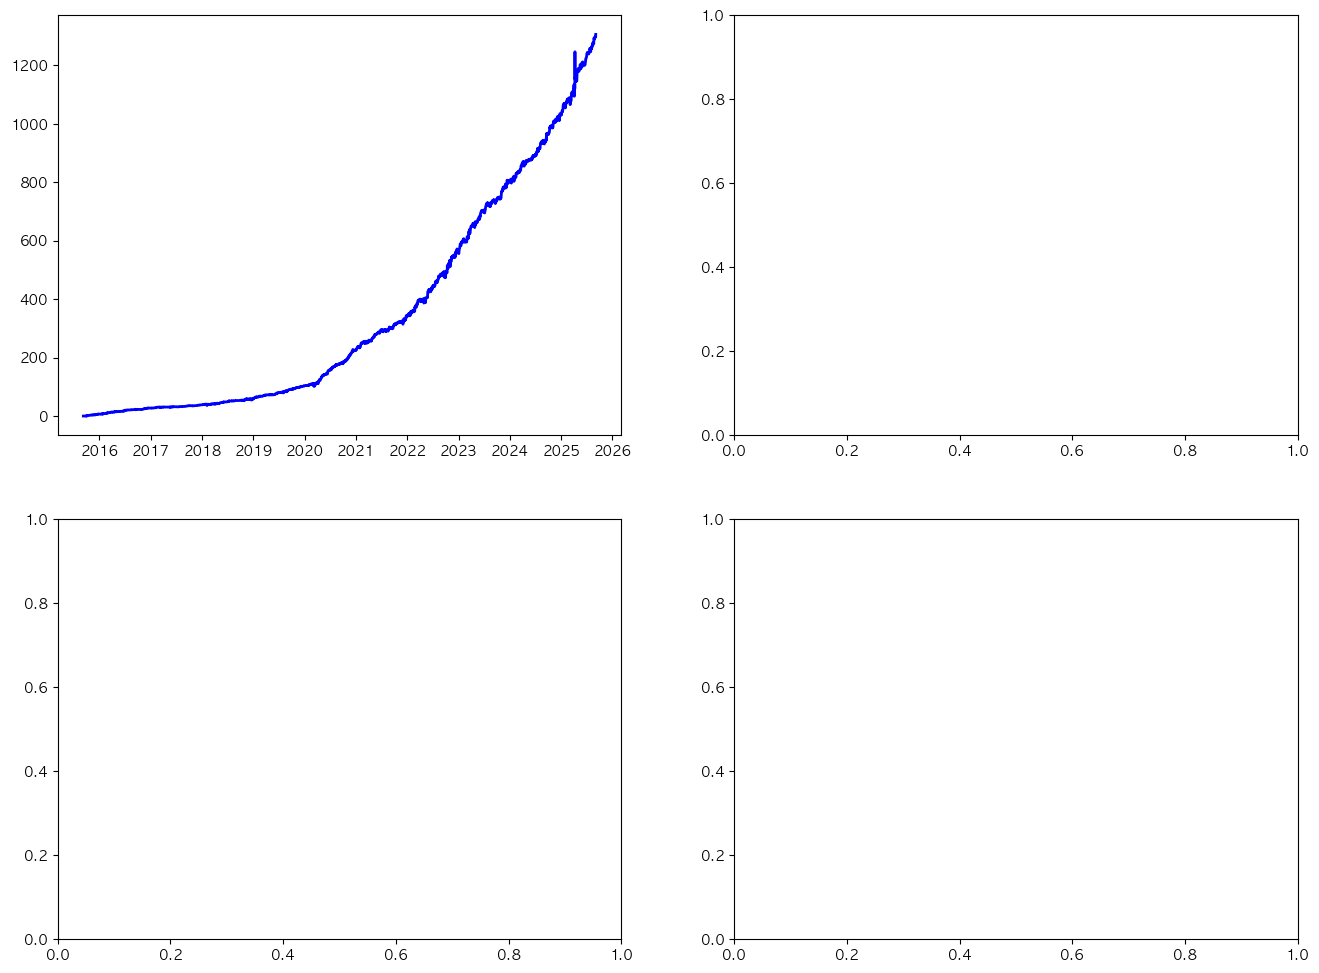

In [76]:
# 포트폴리오 통합 성과 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 통합 포트폴리오 누적 수익률 비교
ax1 = axes[0, 0]
ax1.plot(integrated_portfolio.index, (integrated_portfolio['cumulative_returns'] - 1) * 100, 
         label='균등배분 ATR 전략', linewidth=2, color='blue')
ax1.plot(vol_weighted_portfolio.index, (vol_weighted_portfolio['cumulative_returns'] - 1) * 100, 
         label='변동성가중 ATR 전략', linewidth=2, color='green')
ax1.plot(integrated_portfolio.index, (integrated_portfolio['buy_hold_returns'] - 1) * 100, 
         label='Buy & Hold 포트폴리오', linewidth=2, color='red', alpha=0.7)
ax1.set_title('포트폴리오 통합 성과 비교', fontsize=14)
ax1.set_ylabel('누적 수익률 (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 종목별 비중 변화 (균등배분)
ax2 = axes[0, 1]
for ticker in stock_data.keys():
    ax2.plot(integrated_portfolio.index, integrated_portfolio[f'{ticker}_weight'] * 100, 
             label=ticker, linewidth=1)
ax2.set_title('균등배분 포트폴리오 - 종목별 비중 변화', fontsize=14)
ax2.set_ylabel('비중 (%)')
ax2.set_ylim(0, 30)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. 일별 수익률 분포
ax3 = axes[1, 0]
daily_returns_equal = integrated_portfolio['daily_returns'].dropna()
daily_returns_vol = vol_weighted_portfolio['daily_returns'].dropna()

ax3.hist(daily_returns_equal * 100, bins=50, alpha=0.5, label='균등배분', color='blue', density=True)
ax3.hist(daily_returns_vol * 100, bins=50, alpha=0.5, label='변동성가중', color='green', density=True)
ax3.set_title('일별 수익률 분포', fontsize=14)
ax3.set_xlabel('일별 수익률 (%)')
ax3.set_ylabel('빈도')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. 개별 종목 vs 포트폴리오 성과
ax4 = axes[1, 1]
# 개별 종목 수익률
individual_returns = [(ticker, results['total_return']) for ticker, results in all_results.items()]
individual_returns.sort(key=lambda x: x[1], reverse=True)
tickers = [x[0] for x in individual_returns]
returns = [x[1] for x in individual_returns]

x = np.arange(len(tickers))
width = 0.6

bars = ax4.bar(x, returns, width, label='개별 종목', alpha=0.7, color='lightblue')

# 포트폴리오 수익률 추가
ax4.axhline(y=integrated_results['total_return'], color='blue', linestyle='--', 
            linewidth=2, label=f"균등배분 포트: {integrated_results['total_return']:.1%}")
ax4.axhline(y=vol_weighted_results['total_return'], color='green', linestyle='--', 
            linewidth=2, label=f"변동성가중 포트: {vol_weighted_results['total_return']:.1%}")

ax4.set_title('개별 종목 vs 포트폴리오 수익률', fontsize=14)
ax4.set_ylabel('수익률')
ax4.set_xticks(x)
ax4.set_xticklabels(tickers, rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 위험 대비 수익률 산점도
fig, ax = plt.subplots(figsize=(10, 8))

# 개별 종목
for ticker, results in all_results.items():
    volatility = all_results[ticker]['max_drawdown'] * -100  # MDD를 양수로 변환
    returns = all_results[ticker]['total_return'] * 100
    ax.scatter(volatility, returns, s=100, alpha=0.6, label=ticker)
    ax.annotate(ticker, (volatility, returns), xytext=(5, 5), textcoords='offset points')

# 포트폴리오
port_vol = integrated_results['max_drawdown'] * -100
port_ret = integrated_results['total_return'] * 100
ax.scatter(port_vol, port_ret, s=200, color='blue', marker='D', label='균등배분 포트')
ax.annotate('균등배분', (port_vol, port_ret), xytext=(5, -15), textcoords='offset points')

vol_port_vol = vol_weighted_results['max_drawdown'] * -100
vol_port_ret = vol_weighted_results['total_return'] * 100
ax.scatter(vol_port_vol, vol_port_ret, s=200, color='green', marker='D', label='변동성가중 포트')
ax.annotate('변동성가중', (vol_port_vol, vol_port_ret), xytext=(5, -15), textcoords='offset points')

ax.set_xlabel('최대낙폭 (MDD) %', fontsize=12)
ax.set_ylabel('총 수익률 %', fontsize=12)
ax.set_title('위험(MDD) 대비 수익률 - 개별 종목 vs 포트폴리오', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# 포트폴리오 통합 백테스트 실행
print("=== 포트폴리오 통합 백테스트 ===")
print(f"종목 수: {len(stock_data)}개")
print(f"초기 자본: ${initial_capital:,}")

# 균등 배분 포트폴리오
print("\n1. 균등 배분 포트폴리오")
integrated_trades, integrated_portfolio, ticker_results, integrated_results = portfolio_integrated_backtest(
    stock_data,
    initial_capital=initial_capital,
    atr_entry_multiplier=atr_entry_multiplier,
    stop_loss_atr=stop_loss_atr,
    take_profit_atr=take_profit_atr,
    allocation_method='equal'
)

print(f"\n통합 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${integrated_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {integrated_results['total_return']:.2%}")
print(f"- 샤프 비율: {integrated_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {integrated_results.get('sortino_ratio', 0):.2f}")  # get 메서드로 안전하게 접근
print(f"- 최대 낙폭: {integrated_results['max_drawdown']:.2%}")
print(f"- 총 거래 수: {integrated_results['total_trades']}")

# 종목별 할당 비중 출력
print(f"\n종목별 자본 할당:")
for ticker, results in ticker_results.items():
    allocation = results['allocation']
    print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 변동성 가중 포트폴리오
print("\n2. 변동성 가중 포트폴리오")
vol_weighted_trades, vol_weighted_portfolio, vol_ticker_results, vol_weighted_results = portfolio_integrated_backtest(
    stock_data,
    initial_capital=initial_capital,
    atr_entry_multiplier=atr_entry_multiplier,
    stop_loss_atr=stop_loss_atr,
    take_profit_atr=take_profit_atr,
    allocation_method='volatility_weighted'
)

print(f"\n통합 포트폴리오 성과:")
print(f"- 최종 포트폴리오 가치: ${vol_weighted_results['final_portfolio_value']:,.2f}")
print(f"- 총 수익률: {vol_weighted_results['total_return']:.2%}")
print(f"- 샤프 비율: {vol_weighted_results['sharpe_ratio']:.2f}")
print(f"- 소르티노 비율: {vol_weighted_results.get('sortino_ratio', 0):.2f}")  # get 메서드로 안전하게 접근
print(f"- 최대 낙폭: {vol_weighted_results['max_drawdown']:.2%}")

print(f"\n변동성 가중 종목별 자본 할당:")
for ticker, results in vol_ticker_results.items():
    allocation = results['allocation']
    print(f"- {ticker}: {allocation:.1%} (${allocation * initial_capital:,.0f})")

# 통합 포트폴리오 vs 개별 종목 성과 비교
print("\n=== 통합 포트폴리오 vs 개별 종목 성과 ===")
print(f"{'구분':<15} {'수익률':>12} {'샤프비율':>10} {'MDD':>10}")
print("-" * 50)

# 통합 포트폴리오
print(f"{'균등배분 포트':.<15} {integrated_results['total_return']:>11.1%} {integrated_results['sharpe_ratio']:>10.2f} {integrated_results['max_drawdown']:>9.1%}")
print(f"{'변동성가중 포트':.<15} {vol_weighted_results['total_return']:>11.1%} {vol_weighted_results['sharpe_ratio']:>10.2f} {vol_weighted_results['max_drawdown']:>9.1%}")

# 개별 종목
for ticker, results in all_results.items():
    print(f"{ticker:.<15} {results['total_return']:>11.1%} {results['sharpe_ratio']:>10.2f} {results['max_drawdown']:>9.1%}")

# Buy & Hold 포트폴리오와 비교
bh_return = (integrated_portfolio['buy_hold_returns'].iloc[-1] - 1)
print(f"\n{'Buy&Hold 포트':.<15} {bh_return:>11.1%}")

print(f"\n포트폴리오 초과 수익률:")
print(f"- 균등배분: {integrated_results['total_return'] - bh_return:.1%}")
print(f"- 변동성가중: {vol_weighted_results['total_return'] - bh_return:.1%}")

### 7. 최적 파라미터 탐색

In [ ]:
# 파라미터 그리드 설정
param_grid = {
    'atr_entry': [1.0, 1.5, 2.0, 2.5],
    'stop_loss': [1.0, 1.5, 2.0],
    'take_profit': [2.0, 3.0, 4.0, 5.0]
}

# 첫 번째 종목으로 파라미터 테스트
test_ticker = list(stock_data.keys())[0]
test_df = stock_data[test_ticker]

print(f"\n{test_ticker} 종목으로 파라미터 최적화 진행...")

best_params = None
best_sharpe = -float('inf')
param_results = []

for atr_entry in param_grid['atr_entry']:
    for stop_loss in param_grid['stop_loss']:
        for take_profit in param_grid['take_profit']:
            # 손절선이 익절선보다 큰 경우는 스킵
            if stop_loss >= take_profit:
                continue
            
            # 백테스트 실행
            trades_df, portfolio_df = backtest_atr_strategy(
                test_ticker, test_df, initial_capital,
                atr_entry_multiplier=atr_entry,
                stop_loss_atr=stop_loss,
                take_profit_atr=take_profit
            )
            
            # 결과 분석
            results = analyze_backtest_results(trades_df, portfolio_df, initial_capital)
            
            param_results.append({
                'atr_entry': atr_entry,
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'total_return': results['total_return'],
                'sharpe_ratio': results['sharpe_ratio'],
                'max_drawdown': results['max_drawdown'],
                'total_trades': results['total_trades'],
                'win_rate': results.get('win_rate', 0)
            })
            
            # 최적 파라미터 업데이트 (샤프비율 기준)
            if results['sharpe_ratio'] > best_sharpe:
                best_sharpe = results['sharpe_ratio']
                best_params = {
                    'atr_entry': atr_entry,
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'results': results
                }

# 결과 DataFrame 생성 및 정렬
param_results_df = pd.DataFrame(param_results)
param_results_df = param_results_df.sort_values('sharpe_ratio', ascending=False)

print("\n=== 최적 파라미터 ===")
print(f"ATR 진입 배수: {best_params['atr_entry']}")
print(f"손절선 ATR 배수: {best_params['stop_loss']}")
print(f"익절선 ATR 배수: {best_params['take_profit']}")
print(f"\n성과:")
print(f"- 수익률: {best_params['results']['total_return']:.2%}")
print(f"- 샤프비율: {best_params['results']['sharpe_ratio']:.2f}")
print(f"- 최대낙폭: {best_params['results']['max_drawdown']:.2%}")
print(f"- 승률: {best_params['results'].get('win_rate', 0):.2%}")

# 상위 10개 파라미터 조합 출력
print("\n=== 상위 10개 파라미터 조합 ===")
print(param_results_df.head(10).to_string(index=False))


TQQQ 종목으로 파라미터 최적화 진행...

=== 최적 파라미터 ===
ATR 진입 배수: 1.0
손절선 ATR 배수: 1.5
익절선 ATR 배수: 5.0

성과:
- 수익률: 182.54%
- 샤프비율: 0.87
- 최대낙폭: -12.18%
- 승률: 41.98%

=== 상위 10개 파라미터 조합 ===
 atr_entry  stop_loss  take_profit  total_return  sharpe_ratio  max_drawdown  total_trades  win_rate
       1.0        1.5          5.0      1.825391      0.873380     -0.121781            81  0.419753
       1.0        2.0          5.0      1.080437      0.667664     -0.096808            71  0.464789
       1.5        1.5          5.0      0.777561      0.621963     -0.077066            29  0.517241
       1.0        1.0          5.0      1.473670      0.619932     -0.220615            99  0.292929
       1.5        1.0          5.0      0.697026      0.478341     -0.105213            31  0.419355
       1.5        2.0          5.0      0.531244      0.470542     -0.069778            28  0.535714
       1.0        1.0          4.0      0.955540      0.448817     -0.220600           113  0.300885
       1.0      